import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service
import numpy as np
import imageio
import pandas as pd
import os
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from matplotlib.patches import Circle
import time
import gc
import zipfile
import sys

from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.daf.base as dafBase

import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.sphgeom

from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask

from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask

from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask

afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)


from matplotlib import patches
from shapely.geometry import Point, Polygon
import lsst.afw.image as afwImage
from lsst.geom import SpherePoint, degrees,Point2D, Extent2I
from lsst.afw.display import Display
import warnings
warnings.filterwarnings("ignore", message="Spacing is not a multiple of base spacing")

class Calexp:
    def __init__(self, calexp_data):
        self.calexp_data = calexp_data
        self.expF = butler.get('calexp', **calexp_data)
        self.wcs = self.expF.getWcs()
        self.cut = False
        self.warped  = False

    def pix_to_sky(self, x, y):
        """Convert pixel coordinates to RA and Dec."""
        sphere_point = self.wcs.pixelToSky(geom.Point2D(x, y))
        return sphere_point.getRa().asDegrees(), sphere_point.getDec().asDegrees()

    def sky_to_pix(self, ra, dec):
        """Convert RA and Dec to pixel coordinates."""
        xy = self.wcs.skyToPixel(SpherePoint(ra * degrees, dec * degrees))
        return int(np.round(xy.getX())), int(np.round(xy.getY()))

    def get_corners(self, coord="sky"):
        x0 = float(self.expF.getX0())
        y0 = float(self.expF.getY0())
        width = self.expF.getWidth()
        height = self.expF.getHeight()
        xcorners = [x0, x0+width, x0+width, x0]
        ycorners = [y0, y0, y0+width, y0+width] 
        ra_corners = []
        dec_corners = []
        if coord == "sky":
            for i in range(len(xcorners)):
                ra, dec = self.pix_to_sky(xcorners[i], ycorners[i])
                ra_corners.append(ra)
                dec_corners.append(dec)
            return ra_corners, dec_corners
        else:
            return xcorners, ycorners
            
    def contains(self, ra, dec):
        ra_corners, dec_corners = self.get_corners()
        polygon = Polygon(zip(ra_corners, dec_corners))
        if isinstance(ra, (float, int)):
            point = Point(ra, dec)
            return polygon.contains(point)
        else:
            return [polygon.contains(Point(rai,deci)) for rai, deci in zip(ra,dec)]

    def check_edge(self, ra, dec, d=50):
        """Check if a point is near the edge of the calexp."""
        x, y = self.sky_to_pix(ra, dec)
        bbox = self.expF.getBBox()
    
        # Comprobar si x o y están cerca de los bordes del bounding box
        return (
            abs(bbox.minX - x) < d or 
            abs(bbox.maxX - x) < d or 
            abs(bbox.minY - y) < d or 
            abs(bbox.maxY - y) < d)


    def cutout(self,roi):
        exp=self.expF.getCutout(Point2D(*self.sky_to_pix(*roi[0])), Extent2I(roi[1]))
        cutout = Calexp(self.calexp_data)
        cutout.wcs = exp.getWcs()
        cutout.expF = exp
        return cutout
    

    def plot(self, title=None, fig=None, ax=None, warp=None, roi=None, ticks=8, cut_size=401, col=None, figsize=None, n_ticks = (10,10)):
        '''warp: calexp_ref'''
  
        if fig is None:
            fig = plt.figure(figsize=figsize)
        if ax is None and warp is None:
            ax = plt.subplot(projection=WCS(self.wcs.getFitsMetadata()))
            return_ax = True
        expF = self.expF
        if warp is not None:
            config = RegisterConfig()
            task = RegisterTask(name="register", config=config)
            expF = task.warpExposure(self.expF, self.wcs, calexp_ref.wcs, calexp_ref.expF.getBBox())
            ax = plt.subplot(projection=WCS(calexp_ref.wcs.getFitsMetadata()))
            return_ax = True
        ax.set_title(title, fontsize=8)
        ax.set_xlabel('RA (degrees)', fontsize=8)
        ax.set_ylabel('Dec (degrees)', fontsize=8)
        ax.coords['ra'].set_format_unit(u.deg)

        # ax.coords['ra'].set_ticks(number=n_ticks[0])
        # ax.coords['dec'].set_ticks(number=n_ticks[1])
        ax.coords['ra'].set_ticklabel(rotation=30, fontsize=8, pad = 15)
        # ax.coords['dec'].set_ticklabel(rotation=-30, fontsize=6)

        ra_corners, _ = self.get_corners()
        space = (abs(ra_corners[1]-ra_corners[0]))/(ticks+2)
        if roi is not None:
            space*=(roi[1]/min(self.expF.getDimensions()))
        ax.coords['ra'].set_ticks(spacing=space * u.deg)  
        ax.coords['dec'].set_ticks(spacing=space * u.deg)

        ax.coords['ra'].set_major_formatter('dd:mm:ss')
        ax.coords['dec'].set_major_formatter('dd:mm:ss')
        ax.grid(color='white', ls='--', lw=0.2)
        if roi is not None:
            if warp is None:
                x,y = self.sky_to_pix(*roi[0])
            else:
                x,y = calexp_ref.sky_to_pix(*roi[0])
            size = roi[1]
            ax.set_xlim(x - size / 2, x + size / 2)
            ax.set_ylim(y - size / 2, y + size / 2)
        
        im = plt.imshow(expF.image.array, cmap='gray', vmin=-200.0, vmax=400,origin='lower')
        if return_ax:
            return ax
            
    def add_point(self, ax, ra, dec, r=5, c="r"):
        x, y = self.sky_to_pix(ra,dec)
        circle = Circle((x, y), radius=r, edgecolor=c, facecolor="none")  # Ajusta `radius` como desees
        ax.add_patch(circle)
        
        
dataId = {'visit': 211199, 'detector': 139, 'band': 'i'}
calexp = Calexp(dataId)
dataId_ref = {'visit': 211488, 'detector': 103, 'band': 'i'}
calexp_ref = Calexp(dataId_ref)

In [313]:
import exposures
dataId = {'visit': 211199, 'detector': 139, 'band': 'i'}
calexp = Calexp(dataId)
dataId_ref = {'visit': 211488, 'detector': 103, 'band': 'i'}
calexp_ref = Calexp(dataId_ref)

In [284]:
help(calexp.expF)

Help on ExposureF in module lsst.afw.image._exposure object:

class ExposureF(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      ExposureF
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs) from lsst.afw.image._image._slicing.supportSlicing.<locals>
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other) from lsst.afw.image._image._disableArithmetic.wrapNotImplemented.<locals>
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __deepcopy__(self, memo=None) from lsst.afw.image._exposure._exposureC

In [311]:
print(calexp.calexp_data); print(calexp.expF)
ra, dec = calexp.pix_to_sky(500,500)
print("ra",ra,"dec",dec,type(ra))
x,y = calexp.sky_to_pix(ra, dec)
print("x", x,"y", y,type(x))
ra_corners, dec_corners = calexp.get_corners()
x_corners, y_corners = calexp.get_corners(coord="pix")
print("corners:", "ra", ra_corners, "dec", dec_corners)
print("corners:", "x", x_corners, "y", y_corners)
print(calexp.contains([50,62.2],[30,-36]))
print(calexp.contains(62.2,-36))
ra, dec = calexp.pix_to_sky(10,10)
print("ra",ra,"dec",dec,type(ra))
calexp.check_edge(62.13, -35.75), calexp.check_edge(62.12651,-35.7609, d=10), calexp.check_edge(ra, dec, d=80)

{'visit': 211199, 'detector': 139, 'band': 'i'}
ra 62.126516708328296 dec -35.76091834834366 <class 'float'>
x 500 y 500 <class 'int'>
corners: ra [62.11623355380292, 62.35102852509294, 62.20027281583327, 61.965180214050655] dec [-35.722526925706966, -35.84469113188991, -36.03510894183185, -35.91266882257578]
corners: x [0.0, 4072.0, 4072.0, 0.0] y [0.0, 0.0, 4072.0, 4072.0]
[False, True]
True
ra 62.11643911845412 dec -35.72329477933113 <class 'float'>


(False, False, True)

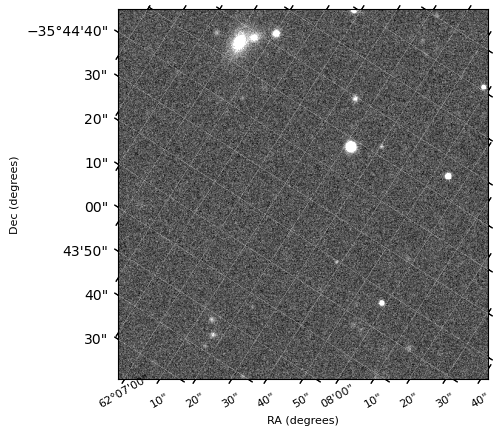

In [286]:
cutout = calexp.cutout(([62.2,-36], 500))
ax=cutout.plot()

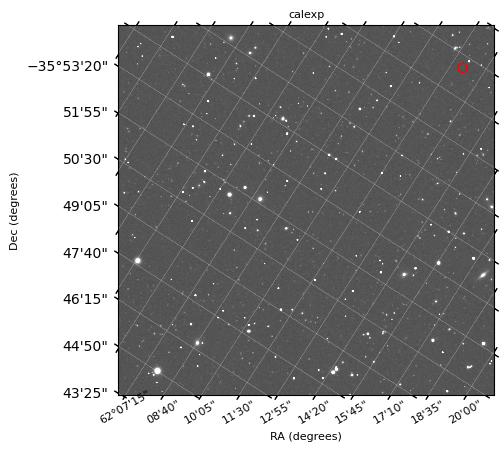

<Figure size 640x480 with 0 Axes>

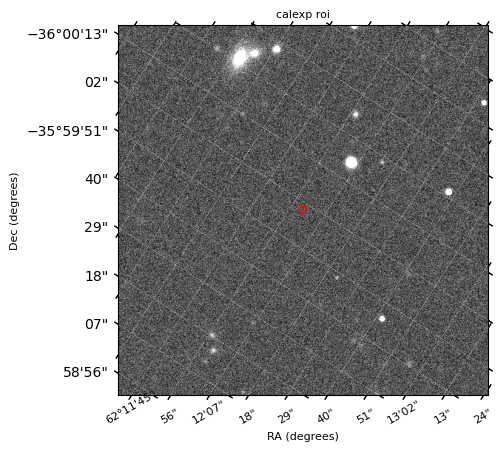

In [289]:
ax = calexp.plot(title="calexp")
calexp.add_point(ax,62.2, -36,r=50)
plt.figure()
ax = calexp.plot(title="calexp roi", roi = ([62.2,-36], 500))
calexp.add_point(ax,62.2, -36)

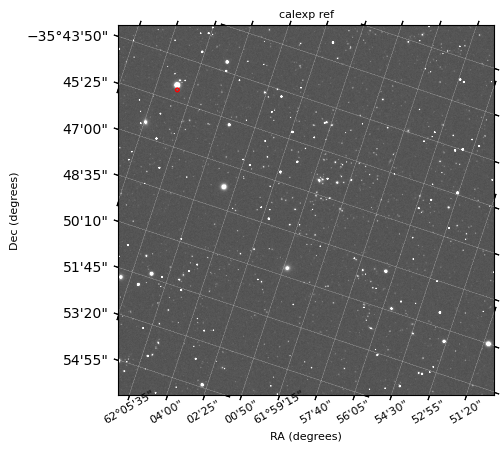

<Figure size 640x480 with 0 Axes>

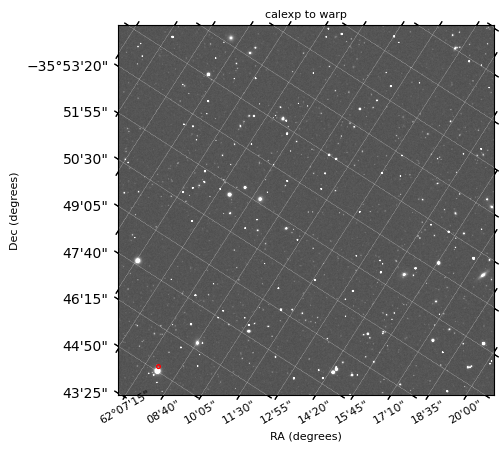

In [301]:
ax = calexp_ref.plot(title="calexp ref")
calexp_ref.add_point(ax,62.13, -35.75, r=20)
plt.figure()
ax = calexp.plot(title="calexp to warp")
calexp.add_point(ax,62.13, -35.75, r=20)

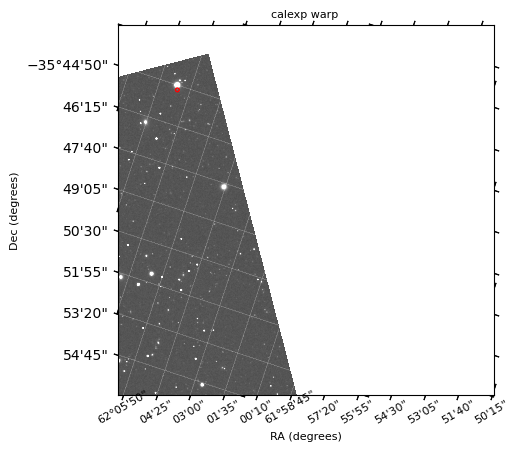

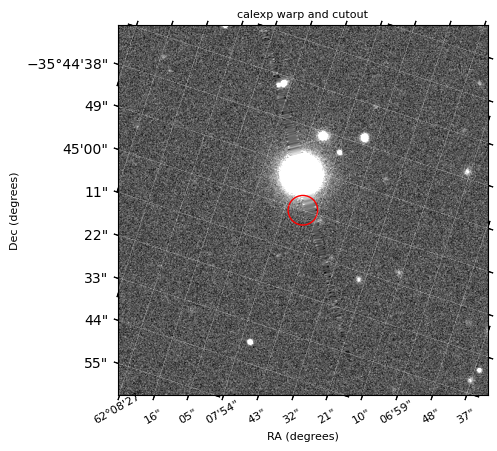

In [297]:
ax = calexp.plot(title="calexp warp ", warp=calexp_ref)
calexp_ref.add_point(ax,62.13, -35.75, r=20)
ax = calexp.plot(title="calexp warp and cutout", roi = ([62.13, -35.75], 500),warp=calexp_ref)
calexp_ref.add_point(ax,62.13, -35.75, r=20)

In [3]:

class LightCurve:
    def __init__ (self, ra=None, dec=None, band="i", data=None, name=None):
        '''data = pd.DataFrame(columns=["Time", "mag", "mag_err", "calexp_detector", "calexp_visit"])'''
        self.ra = ra
        self.dec = dec
        self.htm_id = None
        self.band = band
        if data is None:
            self.data = pd.DataFrame(columns=["Time", "mag", "mag_err", "calexp_detector", "calexp_visit"])
        else:
            self.data = data
        self.name = name 
        s+

    def calculate_htm_id(self, level=20):
        pixelization = lsst.sphgeom.HtmPixelization(level)
        htm_id = pixelization.index(
            lsst.sphgeom.UnitVector3d(
                lsst.sphgeom.LonLat.fromDegrees(self.ra, self.dec)))
        circle = pixelization.triangle(htm_id).getBoundingCircle()
        scale = circle.getOpeningAngle().asDegrees()*3600
        level = pixelization.getLevel()
        print("{:<20}".format(f'({self.ra}, {self.dec})') + f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')
        self.htm_id = htm_id
        return htm_id

    def collect_calexp(self, level=20):
        if not isinstance(self.htm_id, int):
            self.calculate_htm_id(level)
        datasetRefs = list(butler.registry.queryDatasets(
            "calexp", htm20=self.htm_id, where=f"band = '{self.band}'"))
        print("{:<20}".format("") + f"Found {len(datasetRefs)} calexps")
        ccd_visit = butler.get('ccdVisitTable')
        times = []
        detectors = [] ; visits = []
        mags = []
        mag_errs = []

        for calexp_data in datasetRefs:
            did = calexp_data.dataId
            ccdrow = (ccd_visit['visitId'] == did['visit']) & (
                ccd_visit['detector'] == did['detector'])
            exp_midpoint = ccd_visit[ccdrow]['expMidptMJD'].values[0]
            times.append(exp_midpoint)
            detectors.append(did['detector'])  
            visits.append(did['visit'])          
            mags.append(np.nan) ; mag_errs.append(np.nan)  
            
        new_data = pd.DataFrame({
            "Time": times,
            "mag": mags,
            "mag_err": mag_errs,
            "calexp_detector": detectors,
            "calexp_visit": visits})

        new_data = new_data.dropna(axis=1, how='all') # Excluir columnas con todos los valores NA antes de la concatenación
        self.data = pd.concat([self.data, new_data], ignore_index=True)
        self.datasetRefs = datasetRefs  

    def simulate(self, params, model="Pacz", plot=False):
        """
        Simulate magnitudes for a microlensing event and optionally plot the result.
    
        Parameters:
        params (dict): Dictionary containing parameters like t_0, t_E, u_0, and m_base.
        model (str): The model to use for simulation. Default is "Pacz".
        plot (bool): If True, plot the magnification curve.
        
        Returns:
        np.ndarray: Magnitudes corresponding to the times in self.data["Time"].
        """
    
        if model == "Pacz":  # params = {t_0, t_E, u_0, m_base}
            
            def Pacz(t, t_0, t_E, u_0, m_base):
                u_t = np.sqrt(u_0**2 + ((t - t_0) / t_E)**2)
                A_t = (u_t**2 + 2) / (u_t * np.sqrt(u_t**2 + 4))
                return m_base - 2.5 * np.log10(A_t)
            m_t = Pacz(self.data["Time"], **params)
            self.data["mag"] = m_t
            self.name = "Simulated - Pacz"
        else:
            raise ValueError("Model not recognized. Currently supported models: 'Pacz'.")
    
        if plot:
            t_plot = np.linspace(np.min(self.data["Time"]), np.max(self.data["Time"]), 1000)
            m_plot = Pacz(t_plot, **params)
            plt.plot(t_plot, m_plot, color='gray')
            plt.scatter(self.data["Time"], m_t, color='red')
            plt.xlabel('Time')
            plt.ylabel('Magnitude')
            plt.title('Microlensing - Paczynski')
            plt.gca().invert_yaxis() 
            plt.show()

In [4]:
lc = LightCurve(ra = 62.149, dec = -35.796)
lc.calculate_htm_id()
lc.collect_calexp()
params = {"t_0": 60700.5, "t_E": 30, "u_0": 0.5, "m_base": 19.5}
lc.simulate(params, model="Pacz", plot=False)
lc.data

(62.149, -35.796)   HTM ID=9645646590460 at level=20 is bounded by a circle of radius ~0.26 arcsec.
                    Found 137 calexps


/tmp/ipykernel_64317/295424487.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


,Time,mag,mag_err,calexp_detector,calexp_visit
0,59857.349378,19.499997,NaN,38,204710
1,59866.189657,19.499996,NaN,139,211199
2,59866.326085,19.499996,NaN,103,211488
3,59866.353977,19.499996,NaN,121,211540
4,59866.355784,19.499996,NaN,139,211544
...,...,...,...,...,...
132,61364.219722,19.499991,NaN,92,1212007
133,61371.283042,19.499991,NaN,168,1217196
134,61394.161522,19.499992,NaN,73,1231904
135,61394.201148,19.499992,NaN,145,1231987


In [5]:
lc.data.columns

Index(['Time', 'mag', 'mag_err', 'calexp_detector', 'calexp_visit'], dtype='object')

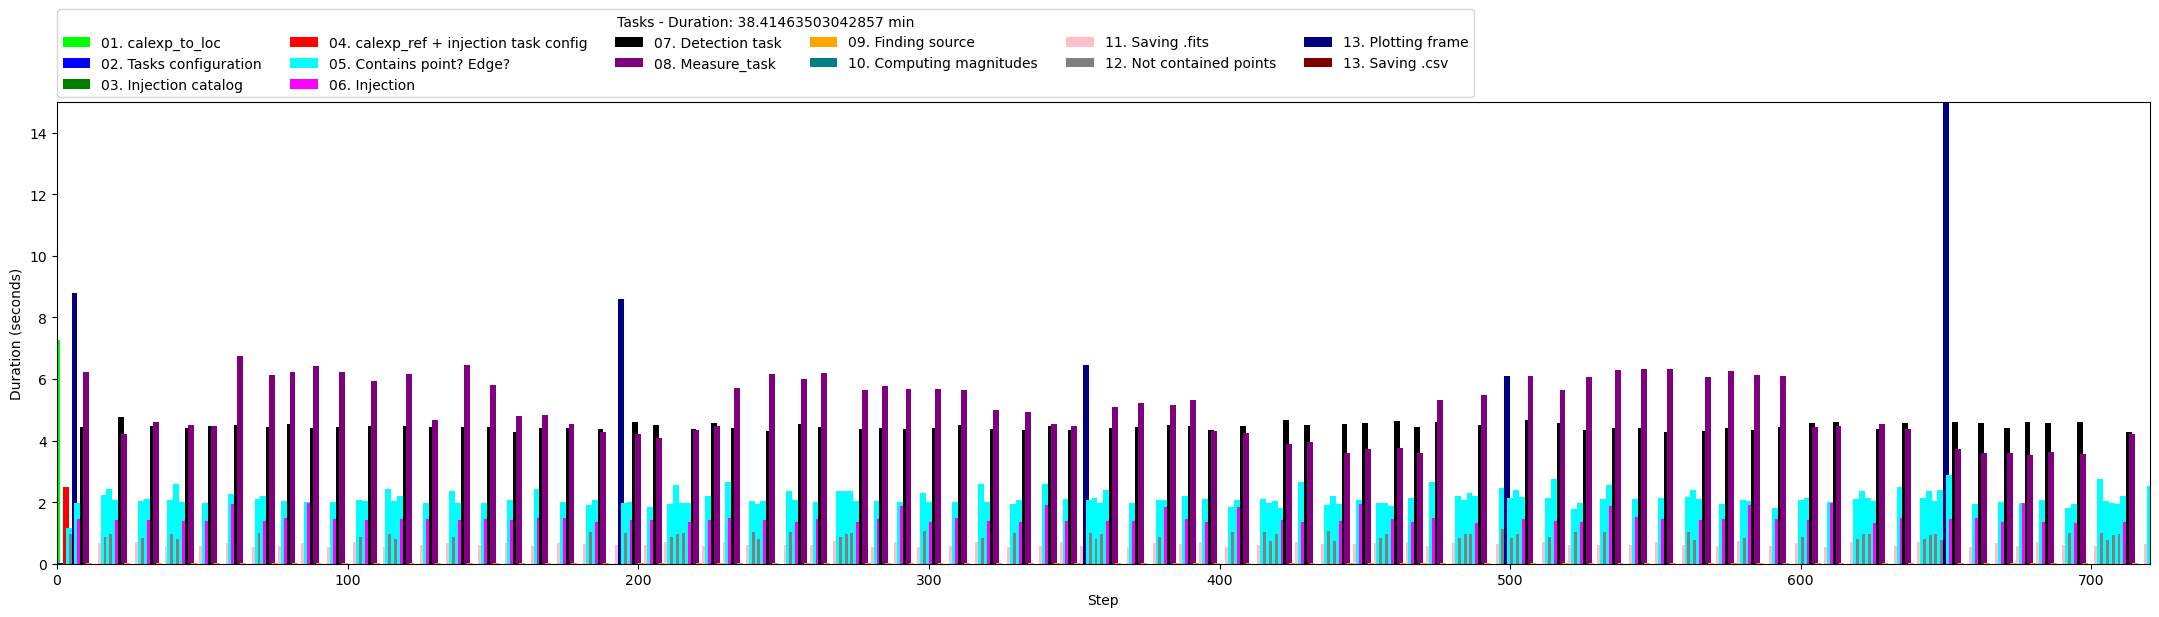

In [70]:
main_path = "runs/20241010_235458/"; n_points = 3; level = 10
df = pd.read_csv(f'{main_path}time_analysis-points{n_points}-HTMlevel{level}.csv')
duration = df["duration"].values
task = df["task"].values
# duration = [j - i for i, j in zip(times[:-1], times[1:])]
colors = ['lime', 'blue', 'green', 'red', 'cyan', 'magenta',  'black', 'purple', 'orange', 
          'teal', 'pink', 'gray', 'navy', 'maroon', 'olive', 'silver', 'aqua',
          'coral', 'turquoise', 'salmon', 'orchid',  'gold', 'plum','yellow', 'brown']
col_task = {i:j for i,j in zip(sorted(set(task)), colors[:len(task)])}
taskcolors=[col_task[i] for i in task]
plt.figure(figsize=(27,6))
plt.xlim(0,720)
plt.ylim(0,15)
plt.bar(range(len(duration)), duration, color=taskcolors, width=2)
for ta in sorted(col_task):
    plt.bar(0, 0, color=col_task[ta], label=ta)  # Barra invisible para crear la leyenda
plt.xlabel("Step")
plt.ylabel("Duration (seconds)")
plt.legend(title=f'Tasks - Duration: {np.sum(duration)/60} min',ncol=6, loc=(0, 1.01))
# data = np.column_stack((np.array([0]+duration, dtype=float), np.array(task, dtype=str)))
# np.savetxt('time_analysis.csv', data, delimiter=',', header="duration,task", comments='', fmt='%s')
plt.savefig(f'{main_path}time_analysis-points{n_points}-HTMlevel{level}.png', bbox_inches='tight')

In [54]:
config = RegisterConfig()
visit = 214463 #lc.data['calexp_visit'][p]
detector = 171 #lc.data['calexp_detector'][p]
dataId = {"visit": visit, "detector": detector}
calexp = butler.get('calexp', **dataId)
task = RegisterTask(name="register", config=config)
warped = task.warpExposure(calexp, calexp_ref.calexp.getWcs(), calexp.getWcs(),calexp_ref.getBBox())


In [53]:
help(task.warpExposure)

Help on method warpExposure in module lsst.pipe.tasks.registerImage:

warpExposure(inputExp, newWcs, templateWcs, templateBBox) method of lsst.pipe.tasks.registerImage.RegisterTask instance
    Warp input exposure to template frame.
    
    There are a variety of data attached to the exposure (e.g., PSF, PhotoCalib
    and other metadata), but we do not attempt to warp these to the template
    frame.
    
    Parameters
    ----------
    inputExp : `lsst.afw.image.Exposure`
        Input exposure, to be warped.
    newWcs : `lsst.afw.geom.SkyWcs`
        Revised Wcs for input exposure.
    templateWcs : `lsst.afw.geom.SkyWcs`
        Target Wcs.
    templateBBox : `lsst.geom.Box`
        Target bounding box.
    
    Returns
    -------
    alignedExp : `lsst.afw.image.Exposure`
        Warped exposure.



In [316]:
visit = lc.data['calexp_visit'][p]
detector = lc.data['calexp_detector'][p]

visit, detector

(214463, 171)

In [181]:
print(calexp_ref.calexp.getWcs().getPixelScale())
calexp_ref.calexp.getWcs()

9.69146e-07 rad


FITS standard SkyWcs:
Sky Origin: (62.0523444966, -35.8538383311)
Pixel Origin: (2193.55, 2037.03)
Pixel Scale: 0.199901 arcsec/pixel

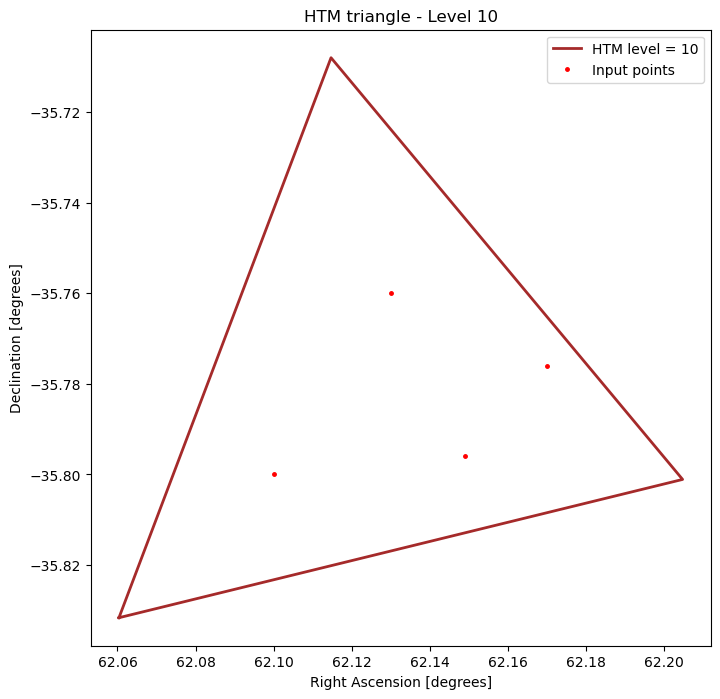

In [74]:
import itertools
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import lsst.sphgeom  # Asegúrate de tener el paquete adecuado

def plot_htm_and_points(level, ra_dec_list, color=None, circle=False, calexp=False, lwT=2, lwC=2, lwc=1):
    # Obtener el primer punto de la lista para generar el triángulo HTM
    ra, dec = ra_dec_list[0]
    
    # Crear el pixelizador HTM para el nivel dado
    pixelization = lsst.sphgeom.HtmPixelization(level)
    
    # Obtener el ID HTM del primer punto
    htm_id = pixelization.index(lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(ra, dec)))
    
    # Obtener los vértices del triángulo HTM
    tri_ra_dec = []
    for uni in pixelization.triangle(htm_id).getVertices():
        tri_ra_dec.append([lsst.sphgeom.LonLat.longitudeOf(uni).asDegrees(), lsst.sphgeom.LonLat.latitudeOf(uni).asDegrees()])
    
    # Crear el polígono del triángulo HTM
    poli = Polygon(tri_ra_dec)
    x, y = poli.exterior.xy
    plt.plot(x, y, alpha=1, color=color, linewidth=lwT, label=f"HTM level = {level}")
    
    ret = []
    
    # Dibujar el círculo delimitador si se solicita
    if circle:
        bounding_circle = pixelization.triangle(htm_id).getBoundingCircle()
        center = bounding_circle.getCenter()
        ra_c, dec_c = lsst.sphgeom.LonLat.longitudeOf(center).asDegrees(), lsst.sphgeom.LonLat.latitudeOf(center).asDegrees()
        radius = bounding_circle.getOpeningAngle().asDegrees()
        circ = plt.Circle((ra_c, dec_c), radius, linewidth=lwC, linestyle="--", color=color, fill=False, label="Bounding circle")
        ret.append(circ)
    
    # Ploteo de los puntos (ra, dec) de la lista
    ra_points, dec_points = zip(*ra_dec_list)
    plt.plot(ra_points, dec_points, ".r", markersize=5, label="Input points")
    
    # Retornar las figuras adicionales si es necesario
    return ret

# Lista de puntos (ra, dec) para ploteo
ra_dec_list = [(62.149, -35.796), (62.1, -35.80), (62.13, -35.76), (62.17, -35.776)]  # Ejemplo de varios puntos

# Colores por nivel de HTM
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown',
          'teal', 'pink', 'gray', 'gold', 'lime', 'navy', 'maroon', 'olive', 'silver', 'aqua',
          'coral', 'turquoise', 'salmon', 'orchid', 'plum']

# Ploteo para un nivel específico, por ejemplo, nivel 10
level = 10

# Crear la figura
plt.figure(figsize=(8,8))

# Llamada a la función para plotear el triángulo HTM y los puntos
plot_htm_and_points(level, ra_dec_list, color=colors[level-1])
# plot_htm_and_points(8, ra_dec_list, color=colors[5])

# Configurar etiquetas y leyenda
plt.title(f"HTM triangle - Level {level}")
plt.xlabel("Right Ascension [degrees]")
plt.ylabel("Declination [degrees]")
plt.legend(loc="best")

# Mostrar el gráfico
plt.show()
